In [1]:
import pandas as pd
import numpy as np
from my_fun import summary_result
from my_fun import plot_result_mergecv
import matplotlib.pyplot as plt
import seaborn as sns

subject_behav = pd.read_csv('result/out01_behav_selected.csv', header = 0, index_col = 0)

scatter_data_ridge = pd.read_csv("result/allsubjects/out02_scatter_data_gender_ridge.csv", sep = ",", header = 0, )
scatter_data_svr = pd.read_csv("result/allsubjects/out02_scatter_data_gender_svr.csv", sep = ",", header = 0, )
scatter_data_gpr = pd.read_csv("result/allsubjects/out02_scatter_data_gender_gpr.csv", sep = ",", header = 0, )
scatter_data_dnn = pd.read_csv("result/allsubjects/out02_scatter_data_gender_dnn.csv", sep = ",", header = 0, )

disorder_info = pd.read_csv("result/disorders/out02_scatter_data_Multi-modal_fit_brainage_ridge.csv", sep = ",", 
                            header = 0, index_col = 0 )
disorder_info.drop(index = ['smry_agr', 'smry_dep'], axis = 0, inplace = True)
disorder_info.reset_index(inplace = True)

# feature_name = 'GMV&rsfMRI'
# feature_name = 'GMV&DTI'
feature_name = 'Multi-modal'

In [2]:
subject_behav.head()

,SUBJID,Sex,ABF_Accuracy,ATT_Accuracy,WM_Accuracy,VMEM_Accuracy,FMEM_Accuracy,SMEM_Accuracy,LAN_Accuracy,NVR_Accuracy,...,FMEM_Speed,SMEM_Speed,LAN_Speed,NVR_Speed,SPA_Speed,EID_Speed,EDI_Speed,ADI_Speed,MOT_Speed,SM_Speed
0,600001676724,F,2.7692,52.0,10.0,38.0,29.0,17.0,14.0,12.0,...,-2193.75,-1943.0,-5716.0,-4385.5,-13567.5,-1729.0,-2714.5,-2158.0,-612.0,-85.66667
1,600003245643,M,2.3810,52.0,5.0,40.0,26.0,15.0,7.0,10.0,...,-2459.75,-2248.0,-6568.0,-6332.0,-8120.0,-1752.0,-3024.0,-1943.5,-592.5,-100.66670
2,600004612332,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,600004963801,F,2.4828,60.0,9.0,39.0,31.0,16.0,11.0,15.0,...,-2835.75,-1728.0,-5407.0,-9775.0,-15727.0,-2087.0,-3223.0,-3823.0,-732.0,-97.33333
4,600005394890,M,0.9419,51.0,8.0,32.0,27.0,12.0,8.0,8.0,...,-1972.25,-1815.5,-5400.0,-3907.0,-8543.5,-1632.0,-2612.0,-2215.5,-656.0,-92.00000


In [3]:
disorder_info.head()

,group,SUBJID,age,predict age,Sex,brain age fit
0,HC,600039015048,11.0,8.769186,M,12.198624
1,HC,601983541597,19.0,16.549809,F,17.343348
2,HC,604718130562,11.0,9.656209,M,12.198624
3,HC,606244059934,16.0,17.060615,F,16.425574
4,HC,609714765360,13.0,14.362010,M,13.736540


In [4]:
def combine_scatter_data(data_list, disorder_info, feature = feature_name):
    out_data_list = []
    for i in range(len(data_list)):
        plot_data = data_list[i]
        plot_data = plot_data.set_index(['feature']).sort_index()
        plot_data = plot_data.loc[feature,:]
        plot_data['age gap corr'] = -plot_data['brain age fit']+plot_data['brain age']
        plot_data['age gap corr sex'] = -plot_data['brain age fit sex']+plot_data['brain age']
        plot_data['age gap corr intersex'] = -plot_data['brain age fit intersex']+plot_data['brain age']
        plot_data['age gap'] = -plot_data['chronological age']+plot_data['brain age']
        
        # add disorder info on plot data:
        plot_data = plot_data.merge(disorder_info.loc[:, ['SUBJID', 'group']], 
                                    left_on = 'SUBJID', right_on = 'SUBJID', how = 'inner')
        
        out_data_list.append(plot_data)
        
    out_data = pd.concat(out_data_list, keys = ['Ridge', 'SVR', 'GPR', 'DNN'], sort = True)
    return(out_data)


In [5]:
scatter_data_list = [scatter_data_ridge, scatter_data_svr, scatter_data_gpr, scatter_data_dnn]
scatter_data = combine_scatter_data(scatter_data_list, disorder_info)
# scatter_data['CV'].value_counts()

# scatter_data_behav = scatter_data.reset_index().merge(subject_behav, how = 'inner', on = ['SUBJID', 'Sex'])
# scatter_data_behav.drop(columns = 'level_1', inplace = True)
# scatter_data_behav.to_csv('result/disorders/out03_scatter_data_allsubjects_trained_'+ feature_name + '.csv')

method_list =scatter_data.index.unique(level=0)
for method in method_list:
    scatter_data_behav = scatter_data.loc[method,:].reset_index().merge(subject_behav, how = 'inner', on = ['SUBJID', 'Sex'])
    #print(scatter_data_behav)
    scatter_data_behav.drop(columns = 'index', inplace = True)
    #scatter_data_behav.to_csv('result/disorders/out03_scatter_data_allsubjects_trained_'+ method + '_' + feature_name + '.csv')
    
    group = scatter_data_behav['group'].unique()
    for g in group:
        scatter_data_behav_g = scatter_data_behav.loc[scatter_data_behav['group']==g, :]
        scatter_data_behav_g.drop(columns = ['CV', 'group'], inplace = True)
        scatter_data_behav_g.to_csv('result/disorders/out03_scatter_data_allsubjects_trained_'+ 
                                  method + '_' + feature_name + '_' + g +  '.csv', index = False)

/home/xin/environments/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [6]:
sns.set(rc={'figure.figsize':(15,15)}, font_scale = 2.5)

def plot_age_gap(plot_data, x_label = 'chronological age', y_label = 'age gap'):
    
    index_name = plot_data.index.unique(level = 0)
    plot_data = plot_data.sort_index()
    
    plot_data2 = plot_data.reset_index()
    plot_data2.rename(columns = {'level_0':'Method'}, inplace = True)
    
    sub_plot = 0

    g = sns.lmplot(x=x_label, y=y_label, hue = 'CV', col = 'Method', \
                       data = plot_data2, fit_reg=False, sharex = True, sharey = True,\
                       scatter_kws={'alpha':0.6}, x_jitter = .2,\
                       height=10.27, aspect=10.27/10.27, legend = False, col_wrap=2)
    g.axes[0].set_xlim(6.5, 22.5)
    
    for i_index in index_name:
        # chronological age vs brain age:
        corr = np.corrcoef(plot_data.loc[(i_index), y_label].values, 
                           plot_data.loc[(i_index), x_label].values)
        label1 = "r cor = %.3f" % corr[0,1]

        
        sns.regplot(x=x_label, y=y_label, \
                    data = plot_data.loc[i_index], scatter=False, ax=g.axes[sub_plot], order = 1)

        #text_y = plot_data['age gap'].max()+.2
        g.axes[sub_plot].text(18, 5, label1, fontsize = 25)
        
        g.axes[sub_plot].set_title(i_index)
        if sub_plot<2:
            g.axes[sub_plot].set_xlabel('')
        if sub_plot%2 == 1:
            g.axes[sub_plot].set_ylabel('')
        sub_plot = sub_plot + 1
        
        #g.axes[0, 0].set_ylim(8, 23)
    g.axes[0].set_ylabel(y_label)
    g.axes[2].set_ylabel(y_label)

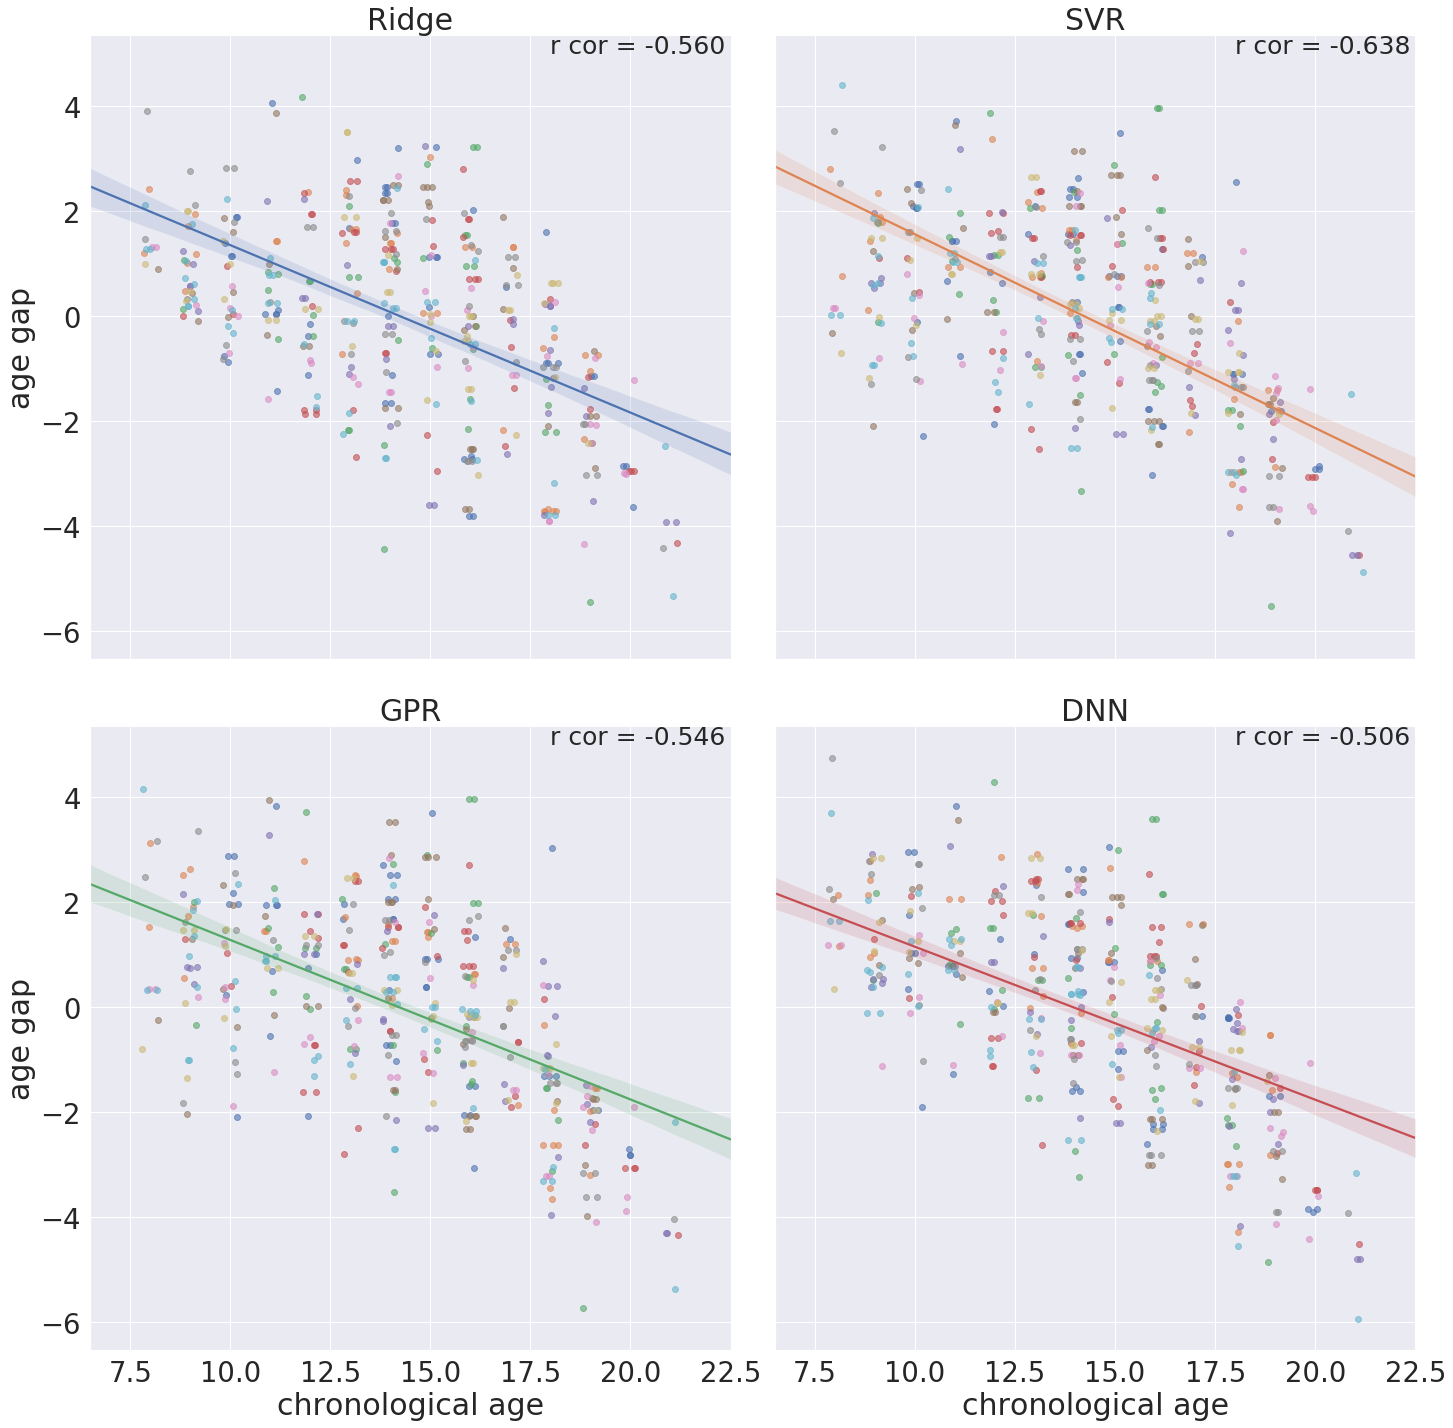

In [7]:
plot_age_gap(scatter_data)

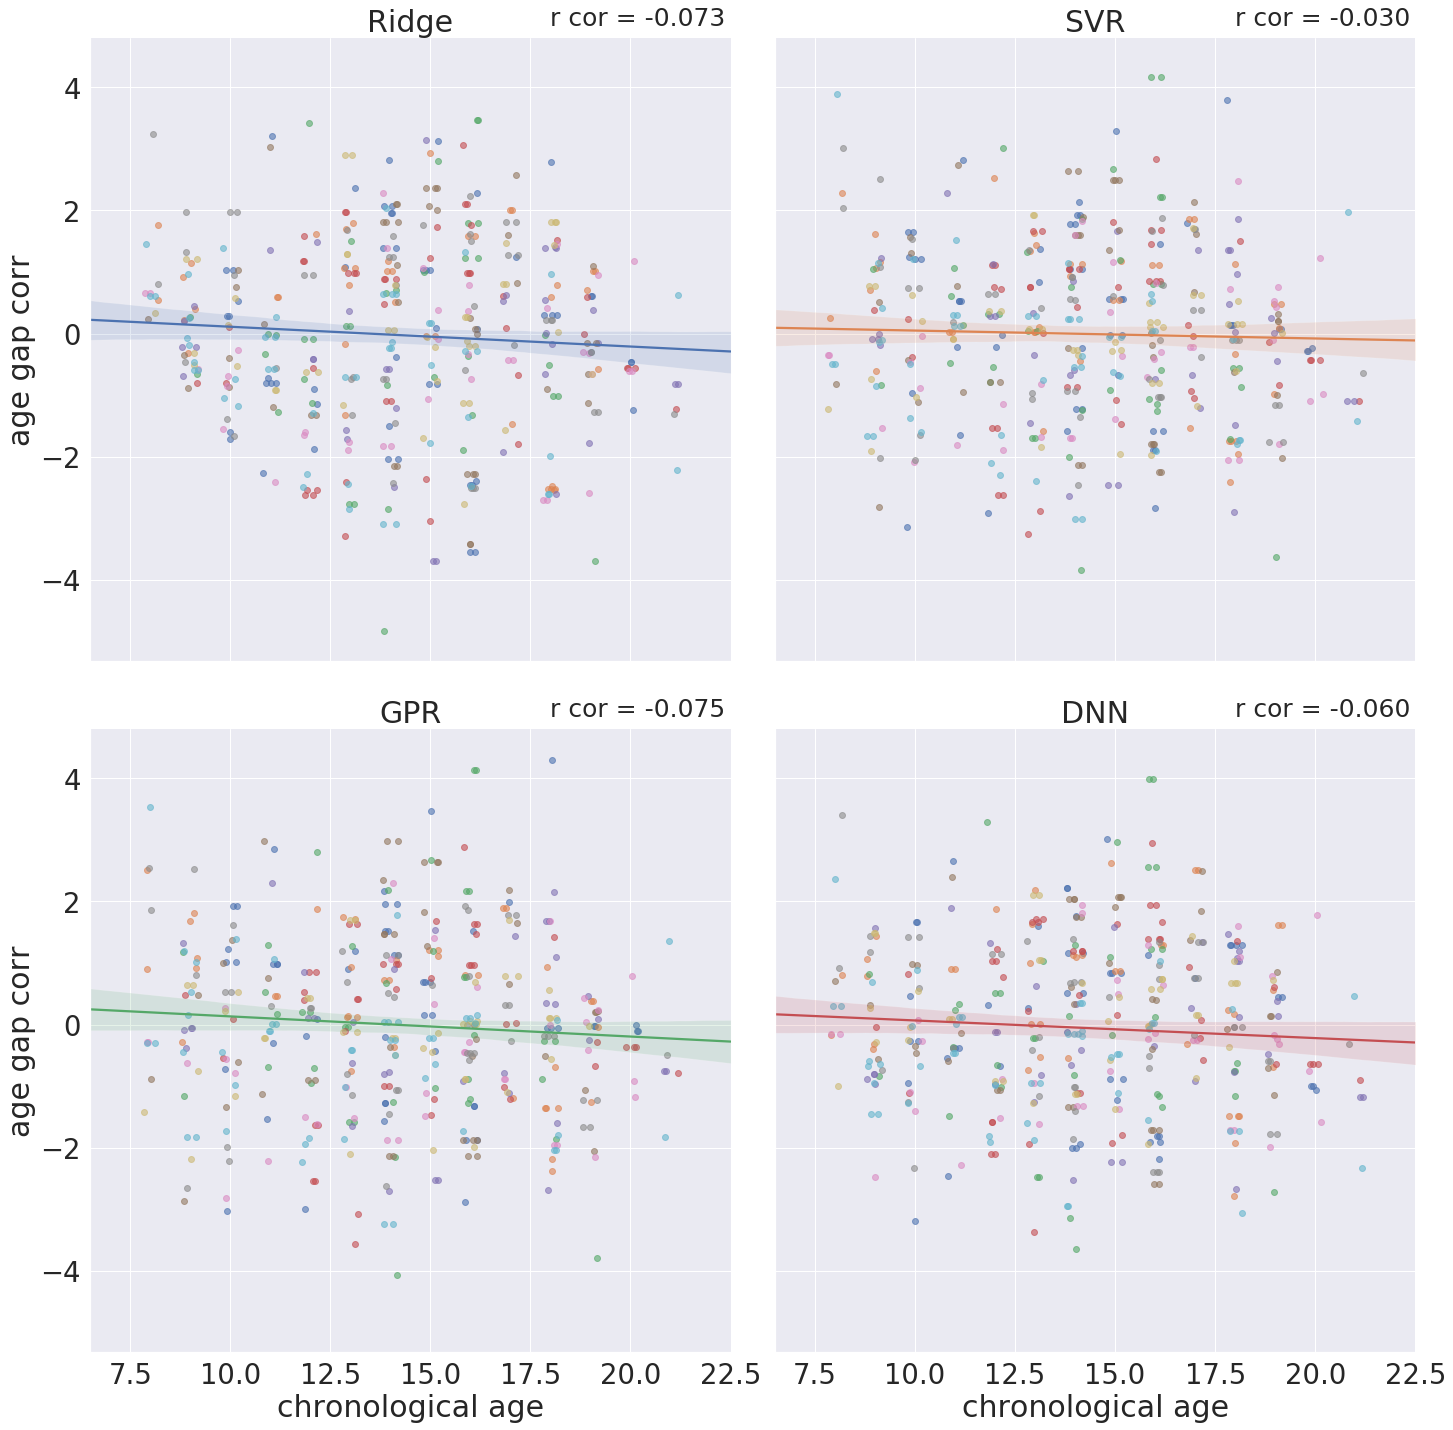

In [8]:
plot_age_gap(scatter_data, 'chronological age', 'age gap corr')

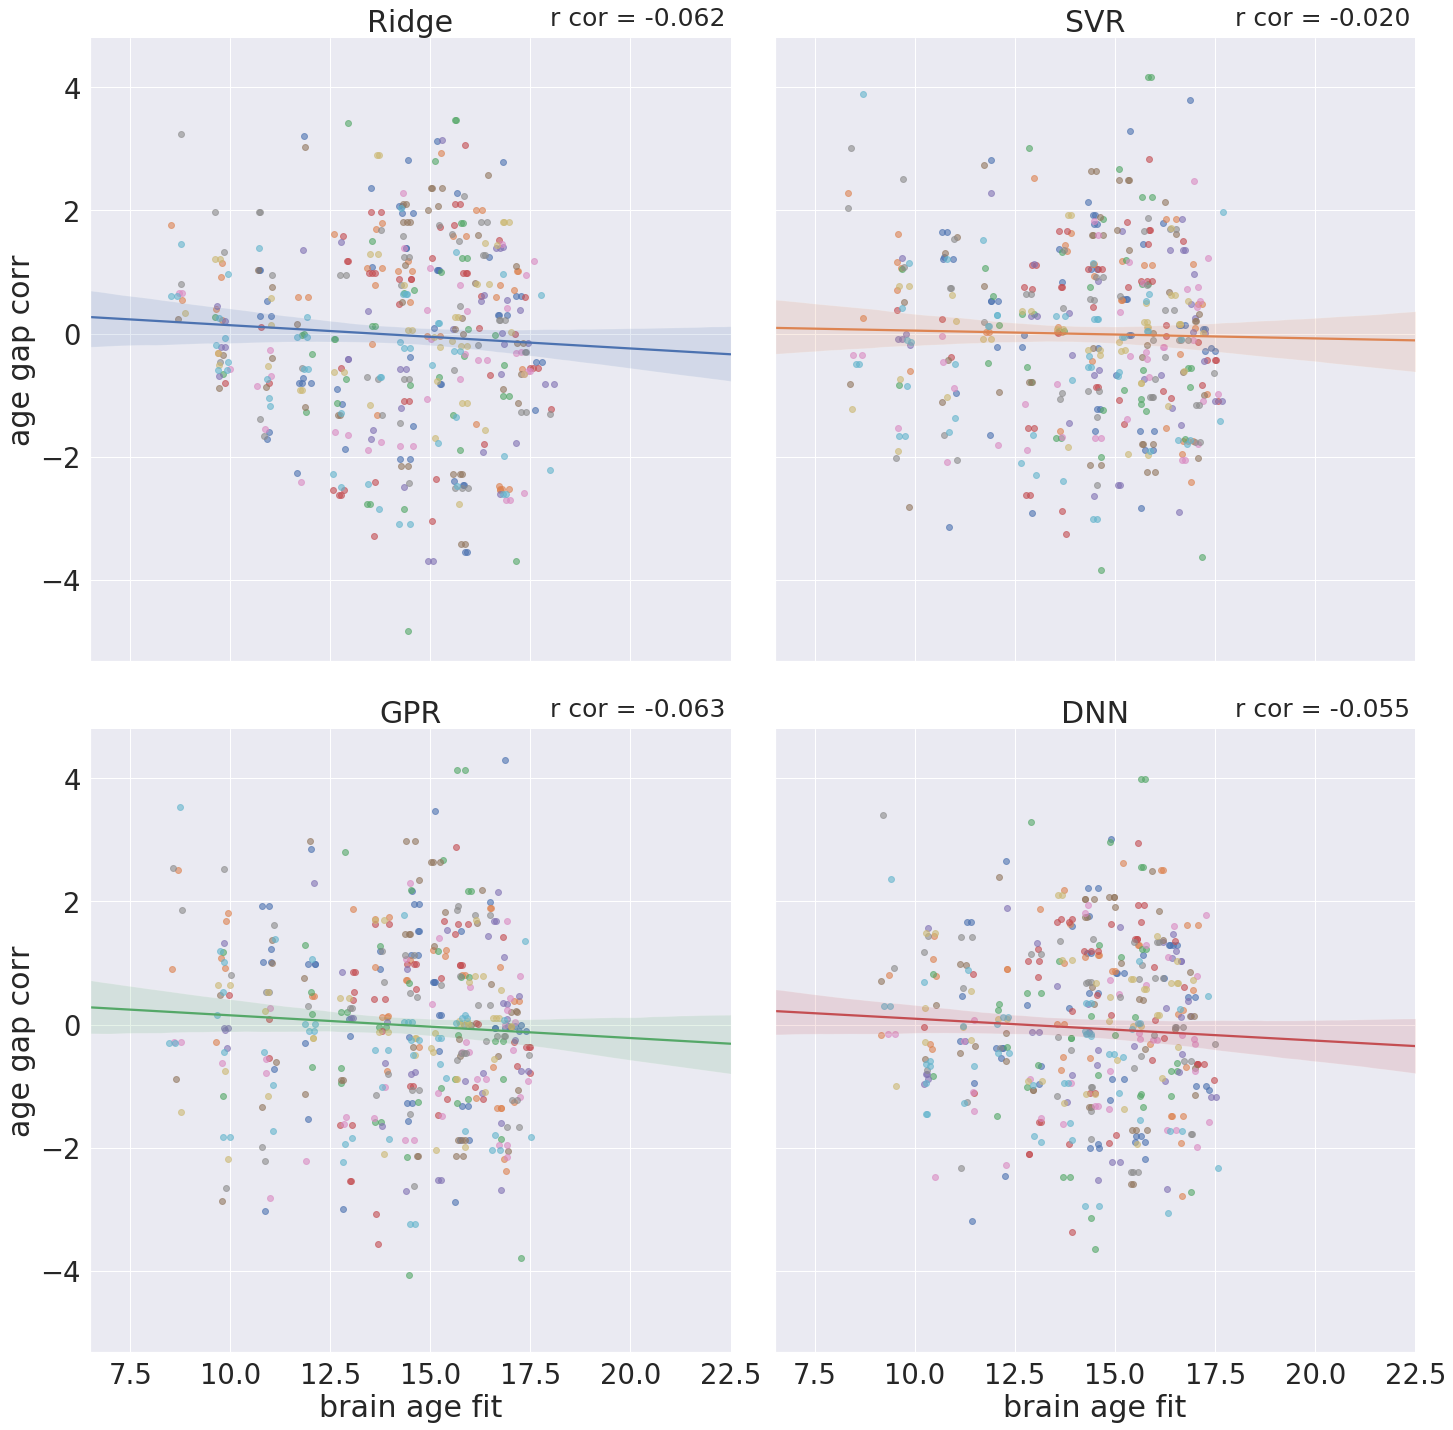

In [9]:
plot_age_gap(scatter_data, 'brain age fit', 'age gap corr')

In [10]:
from my_fun import qudratic_r_squared


def plot_result_gender(plot_data):

    index_name = plot_data.index.unique(level = 0)
    
    plot_data = plot_data.sort_index()
#     result_table_summary = result_table_summary.sort_index()
    
    plot_data2 = plot_data.reset_index()
    plot_data2.rename(columns = {'level_0':'Method'}, inplace = True)
    
    sub_plot = 0
    sns.set(rc={'figure.figsize':(15,15)}, font_scale = 2.5)

    g = sns.lmplot(x='chronological age', y='brain age', hue = 'Sex', col = 'Method', \
                       data = plot_data2, fit_reg=True, order = 2, sharex = True, sharey = True,\
                       scatter_kws={'alpha':0.6}, x_jitter = .2,\
                       height=10.27, aspect=10.27/10.27, legend = True, col_wrap=2)
    
    g.axes[0].set_xlim(6.5, 22.5)
    g.axes[0].set_ylim(5.5, 22.5)
    
    for i_index in index_name:
        plot_data_i = plot_data.loc[i_index]
        chro_age_m = plot_data_i.loc[plot_data_i['Sex']=='M','brain age fit'].values
        chro_age_f = plot_data_i.loc[plot_data_i['Sex']=='F','brain age fit'].values
        
        brain_age_m = plot_data_i.loc[plot_data_i['Sex']=='M','brain age'].values
        brain_age_f = plot_data_i.loc[plot_data_i['Sex']=='F','brain age'].values
        
        
        # chronological age vs age gap:
        label2 = "Male: $R^2$ cor = %.3f, MAE cor = %.3f" % \
        (qudratic_r_squared(chro_age_m, brain_age_m),\
         np.mean(np.abs(chro_age_m - brain_age_m)))
        
        label1 = "Female: $R^2$ cor = %.3f, MAE cor = %.3f" % \
        (qudratic_r_squared(chro_age_f, brain_age_f),\
         np.mean(np.abs(chro_age_f - brain_age_f)))


        #text_y = plot_data['brain age'].max()+.2
        g.axes[sub_plot].text(8, 20.5, label1, fontsize = 25)
        g.axes[sub_plot].text(8, 21.4, label2, fontsize = 25)
        
        g.axes[sub_plot].set_title(i_index)
        if sub_plot<2:
            g.axes[sub_plot].set_xlabel('')
        if sub_plot%2 == 1:
            g.axes[sub_plot].set_ylabel('')
        sub_plot = sub_plot + 1
        
        #g.axes[0, 0].set_ylim(8, 23)

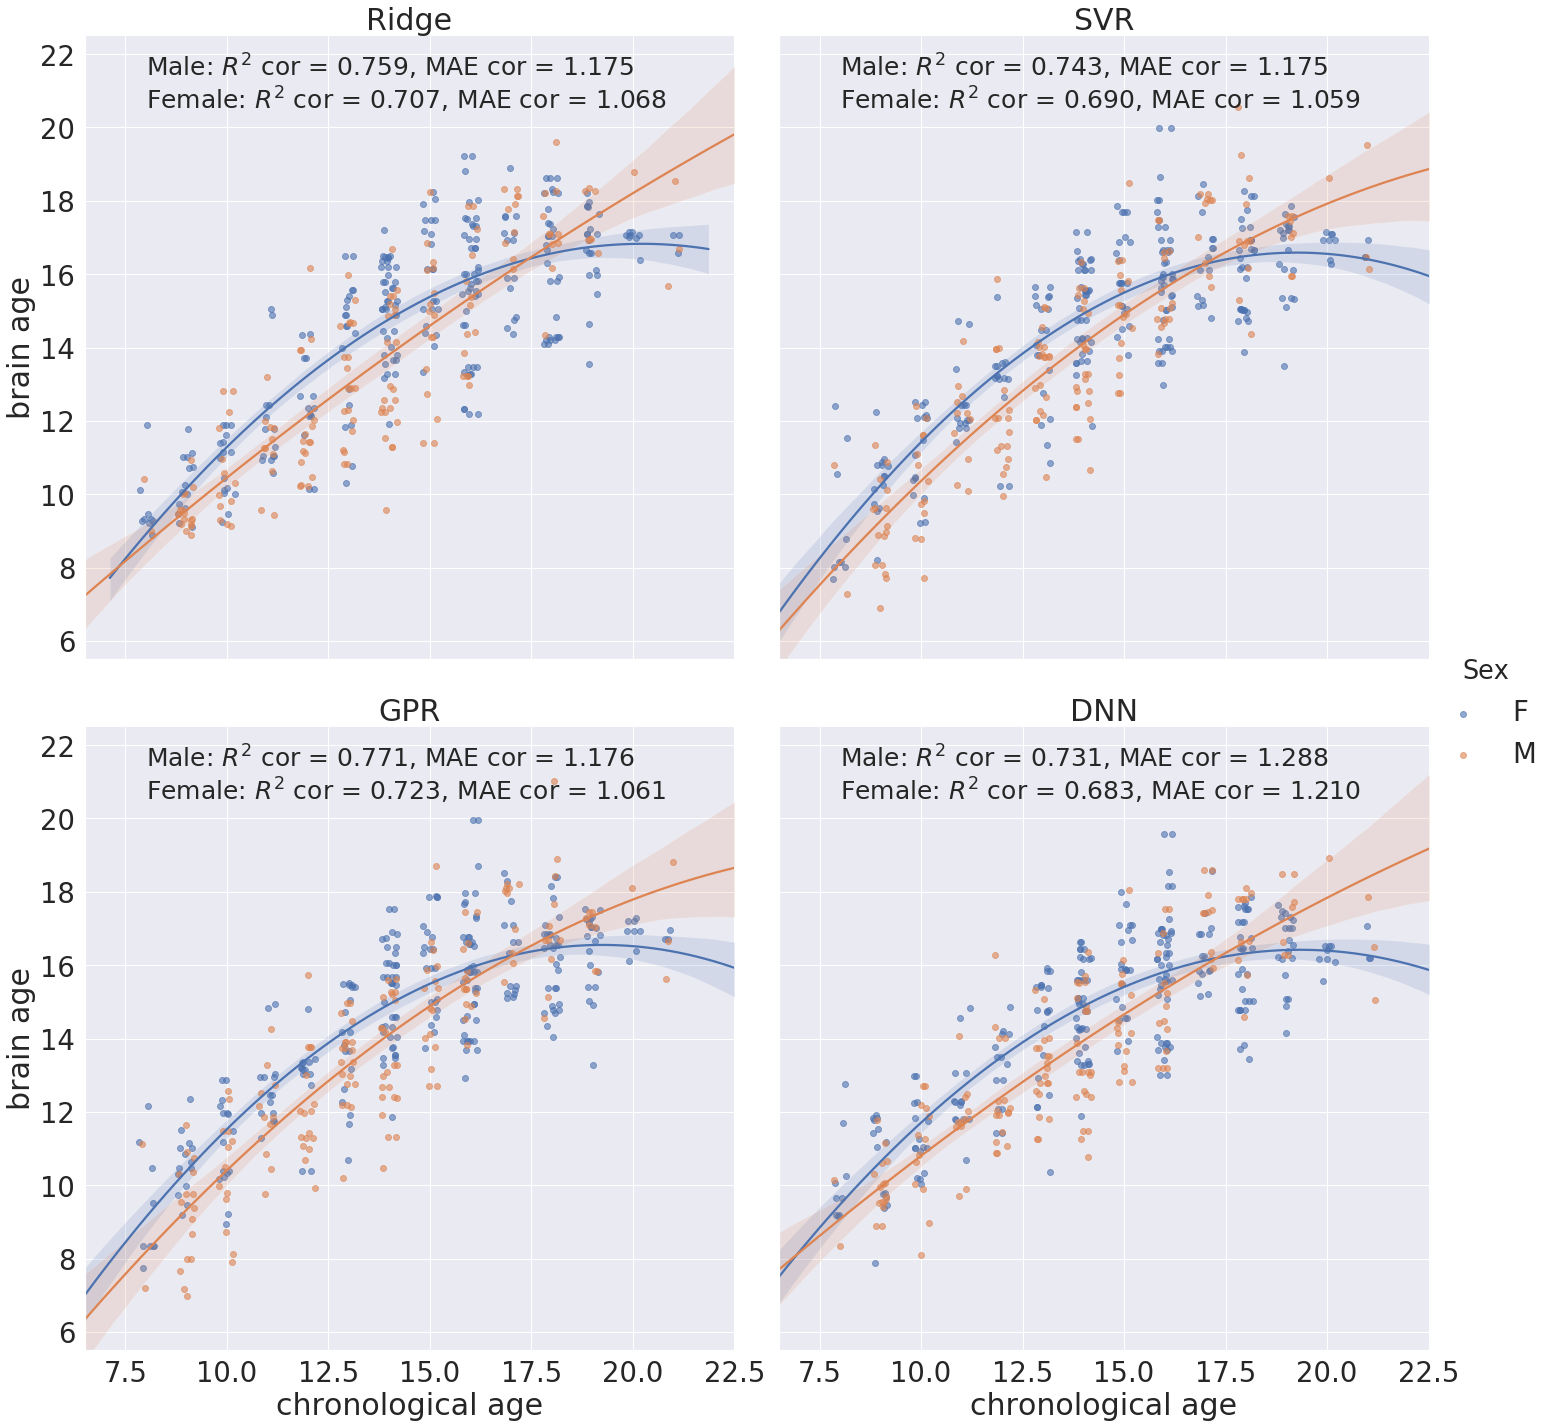

In [11]:
plot_result_gender(scatter_data)

In [12]:
def plot_age_gap_gender(plot_data, x_label = 'chronological age', y_label = 'age gap corr'):

    index_name = plot_data.index.unique(level = 0)
    
    plot_data = plot_data.sort_index()
    
    plot_data2 = plot_data.reset_index()
    plot_data2.rename(columns = {'level_0':'Method'}, inplace = True)
    
    sub_plot = 0
    sns.set(rc={'figure.figsize':(15,15)}, font_scale = 2.5)

    g = sns.lmplot(x=x_label, y=y_label, hue = 'Sex', col = 'Method', \
                       data = plot_data2, fit_reg=True, order = 1, sharex = True, sharey = True,\
                       scatter_kws={'alpha':0.6}, x_jitter = .2,\
                       height=10.27, aspect=10.27/10.27, legend = True, col_wrap=2)
    
    g.axes[0].set_ylabel('age gap cor')
    g.axes[2].set_ylabel('age gap cor')
    g.axes[0].set_xlim(6.5, 22.5)
    g.axes[0].set_ylim(-6.5, 6.5)
    
    for i_index in index_name:
        plot_data_i = plot_data.loc[(i_index)]

        x_male = plot_data_i.loc[plot_data_i['Sex']=='M', x_label].values
        x_female = plot_data_i.loc[plot_data_i['Sex']=='F', x_label].values
        
        y_male = plot_data_i.loc[plot_data_i['Sex']=='M', y_label].values
        y_female = plot_data_i.loc[plot_data_i['Sex']=='F', y_label].values

        corr_m = np.corrcoef(x_male, y_male)[0,1]
        corr_f = np.corrcoef(x_female, y_female)[0,1]
        
        # chronological age vs brain age:
        label2 = "Male: r cor = %.3f" % corr_m
        label1 = "Female: r cor = %.3f" % corr_f


        #text_y = plot_data['brain age'].max()+.2
        g.axes[sub_plot].text(16, 5, label1, fontsize = 25)
        g.axes[sub_plot].text(16, 5.5, label2, fontsize = 25)
        
        g.axes[sub_plot].set_title(i_index)
        if sub_plot<2:
            g.axes[sub_plot].set_xlabel('')
        if sub_plot%2 == 1:
            g.axes[sub_plot].set_ylabel('')
        sub_plot = sub_plot + 1
        
        #g.axes[0, 0].set_ylim(8, 23)

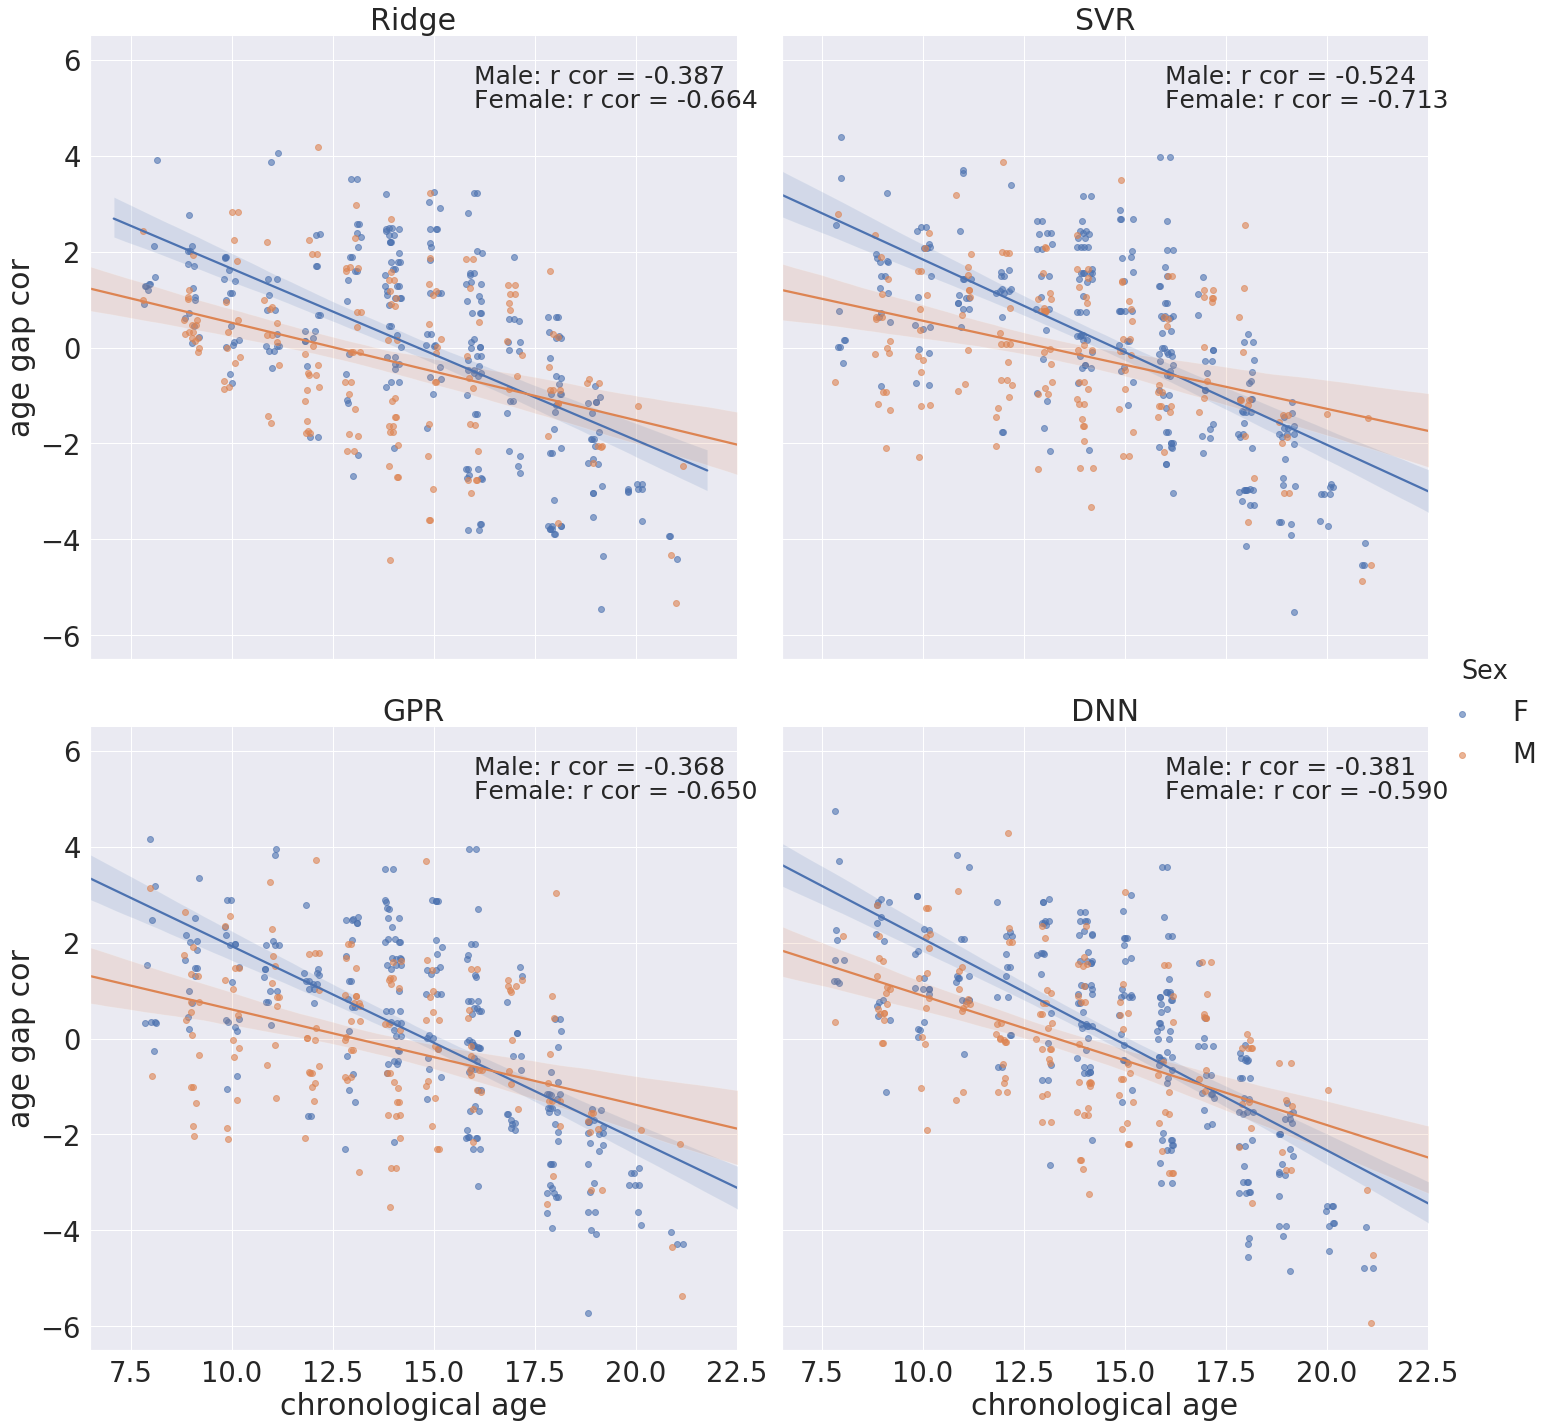

In [13]:
plot_age_gap_gender(scatter_data, 'chronological age', 'age gap')

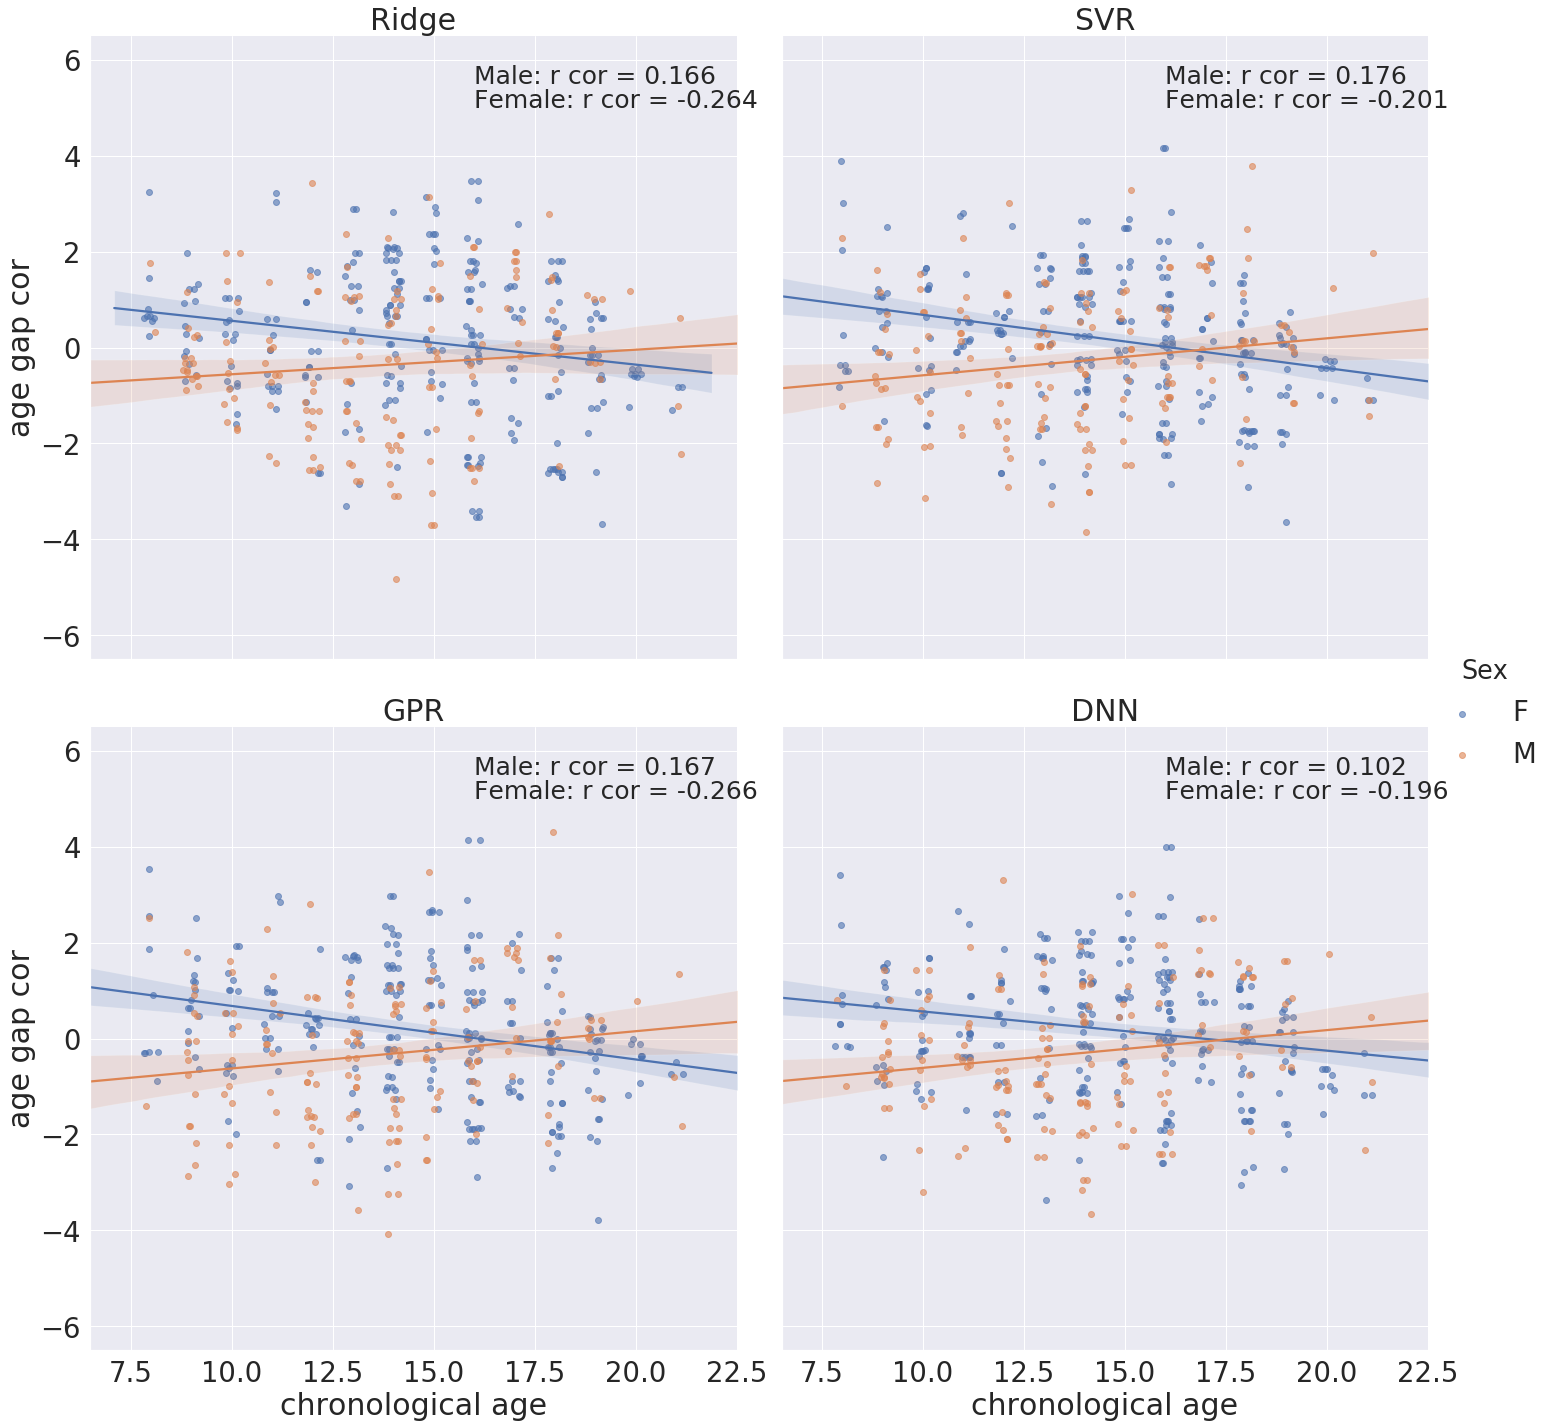

In [14]:
plot_age_gap_gender(scatter_data)

# plot for disorder groups:

In [15]:
from my_fun import qudratic_r_squared_gender

disorders_name = ['HC', 'Specific phobia', 'PTSD', 'Social phobia']
disorders = ['HC', 'smry_phb', 'smry_ptd', 'smry_soc']

def plot_result_group(plot_data):

    index_name = plot_data.index.unique(level = 0)
    
    # bug report: sort index changes the order of grid facet plot but the labels remains the same
#     plot_data = plot_data.sort_index() 
#     result_table_summary = result_table_summary.sort_index()
    
    plot_data2 = plot_data.reset_index()
    plot_data2.rename(columns = {'level_0':'Method'}, inplace = True)
    
    
    sns.set(rc={'figure.figsize':(15,15)}, font_scale = 2.5)

    g = sns.FacetGrid(hue = 'group', col = 'Method', \
                       data = plot_data2, sharex = True, sharey = True,\
                       height=10.27, aspect=10.27/10.27, col_wrap=2)
    
    g.axes[0].set_xlim(6.5, 22.5)
    g.axes[0].set_ylim(5.5, 24.5)
    
    color = ['b', 'g', 'r', 'y']
    
    sub_plot = 0
    for i_index in index_name:
        plot_data_i = plot_data2.loc[plot_data2['Method']==i_index,:]
        plot_data_i['Sex'].replace({'F': 0, 'M': 1}, inplace = True)
        for i_dis in range(len(disorders)):

            y_dis = plot_data_i.loc[plot_data_i['group']==disorders[i_dis], 'chronological age']
            y_pred = plot_data_i.loc[plot_data_i['group']==disorders[i_dis], 'brain age']
            gender = plot_data_i.loc[plot_data_i['group']==disorders[i_dis], 'Sex']

            r_dis = np.corrcoef(y_dis, y_pred)
            r_squared = qudratic_r_squared_gender(y_dis, y_pred, gender)
#             r_squared = qudratic_r_squared(y_dis, y_pred)
            rmse_dis = np.sqrt(np.mean(np.square(y_dis - y_pred)))
            mae_dis = np.mean(np.abs(y_dis - y_pred))

            #label = disorders[i_dis] + ": r = %.3f MAE = %.3f" % (r_dis[1,0], mae_dis)
            label = disorders_name[i_dis] + ": $R^2$ = %.3f MAE = %.3f" % (r_squared, mae_dis)

            ax = sns.regplot(x=y_dis, y=y_pred, label = label, order = 2, 
                             scatter_kws = {'alpha': .6}, color = color[i_dis],\
                             x_jitter = 0.2, ax = g.axes[sub_plot])
            
            ax.legend(loc="upper left", fontsize = 21, labelspacing = .3)
            #ax.legend(loc="lower right", fontsize = 20, labelspacing = .3)
            #ax.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), ncol=1)
            #ax.set(xlabel='chronological age', ylabel='brain age')
            #ax.set(ylim = [5, 22])
            #ax.set(xlim = [7, 22])
        
        g.axes[sub_plot].set_title(i_index)
        if sub_plot<2:
            g.axes[sub_plot].set_xlabel('')
        if sub_plot%2 == 1:
            g.axes[sub_plot].set_ylabel('')
        sub_plot = sub_plot + 1
        
        #g.axes[0, 0].set_ylim(8, 23)
        
def plot_result_group_single_method(plot_data, method):

    index_name = plot_data.index.unique(level = 0)
    
    # bug report: sort index changes the order of grid facet plot but the labels remains the same
#     plot_data = plot_data.sort_index() 
#     result_table_summary = result_table_summary.sort_index()
    
    plot_data2 = plot_data.reset_index()
    plot_data2.rename(columns = {'level_0':'Method'}, inplace = True)
    
    sns.set(rc={'figure.figsize':(15,15)}, font_scale = 2.5)
    color = ['b', 'g', 'r', 'y']

    plot_data_i = plot_data2.loc[plot_data2['Method']==method,:]
    plot_data_i['Sex'].replace({'F': 0, 'M': 1}, inplace = True)
    for i_dis in range(len(disorders)):

        y_dis = plot_data_i.loc[plot_data_i['group']==disorders[i_dis], 'chronological age']
        y_pred = plot_data_i.loc[plot_data_i['group']==disorders[i_dis], 'brain age']
        gender = plot_data_i.loc[plot_data_i['group']==disorders[i_dis], 'Sex']

        r_dis = np.corrcoef(y_dis, y_pred)
        r_squared = qudratic_r_squared_gender(y_dis, y_pred, gender)
#             r_squared = qudratic_r_squared(y_dis, y_pred)
        rmse_dis = np.sqrt(np.mean(np.square(y_dis - y_pred)))
        mae_dis = np.mean(np.abs(y_dis - y_pred))

        #label = disorders[i_dis] + ": r = %.3f MAE = %.3f" % (r_dis[1,0], mae_dis)
        label = disorders_name[i_dis] + ": $R^2$ = %.3f MAE = %.3f" % (r_squared, mae_dis)

        ax = sns.regplot(x=y_dis, y=y_pred, label = label, order = 2, 
                         scatter_kws = {'alpha': .6}, color = color[i_dis],\
                         x_jitter = 0.2)

        ax.legend(loc="upper left", fontsize = 19, labelspacing = .3)
        #ax.legend(loc="lower right", fontsize = 20, labelspacing = .3)
        #ax.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), ncol=1)
        ax.set(xlabel='Chronological Age', ylabel='Brain Age')
        ax.set(ylim = [6.5, 22.5])
        ax.set(xlim = [5.5, 22.5])

    ax.set_title(method)
    plt.subplots_adjust(left = .075, bottom = .07, right = .95, top = .95)
        
    #g.axes[0, 0].set_ylim(8, 23)

/home/xin/environments/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


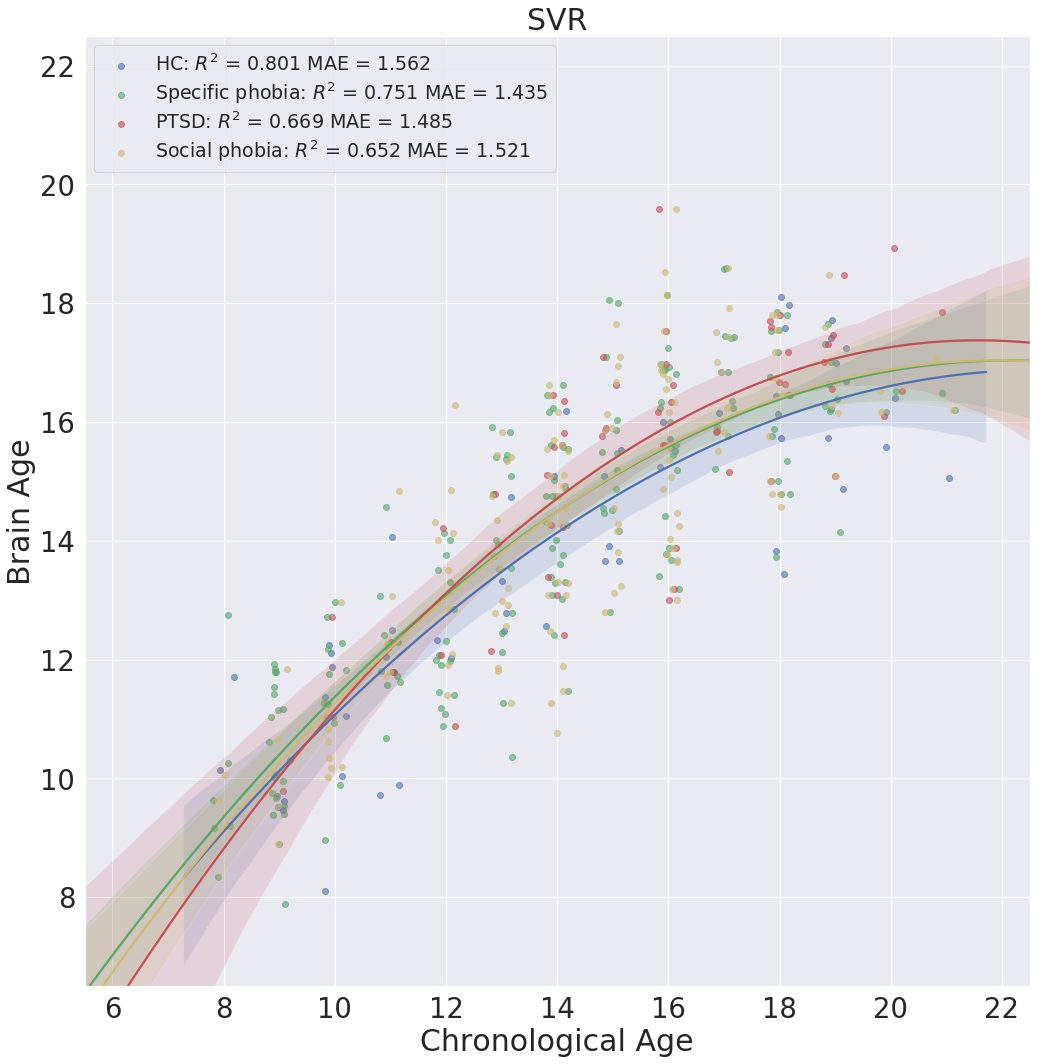

In [16]:
plot_result_group_single_method(scatter_data, 'SVR')
#plt.savefig('figure/figure4_scatter_disorders_SVR.png', format = 'png', dpi=300)
plt.savefig('figure/figure4_scatter_disorders_SVR.jpg', format = 'jpg', dpi=300)

/home/xin/environments/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


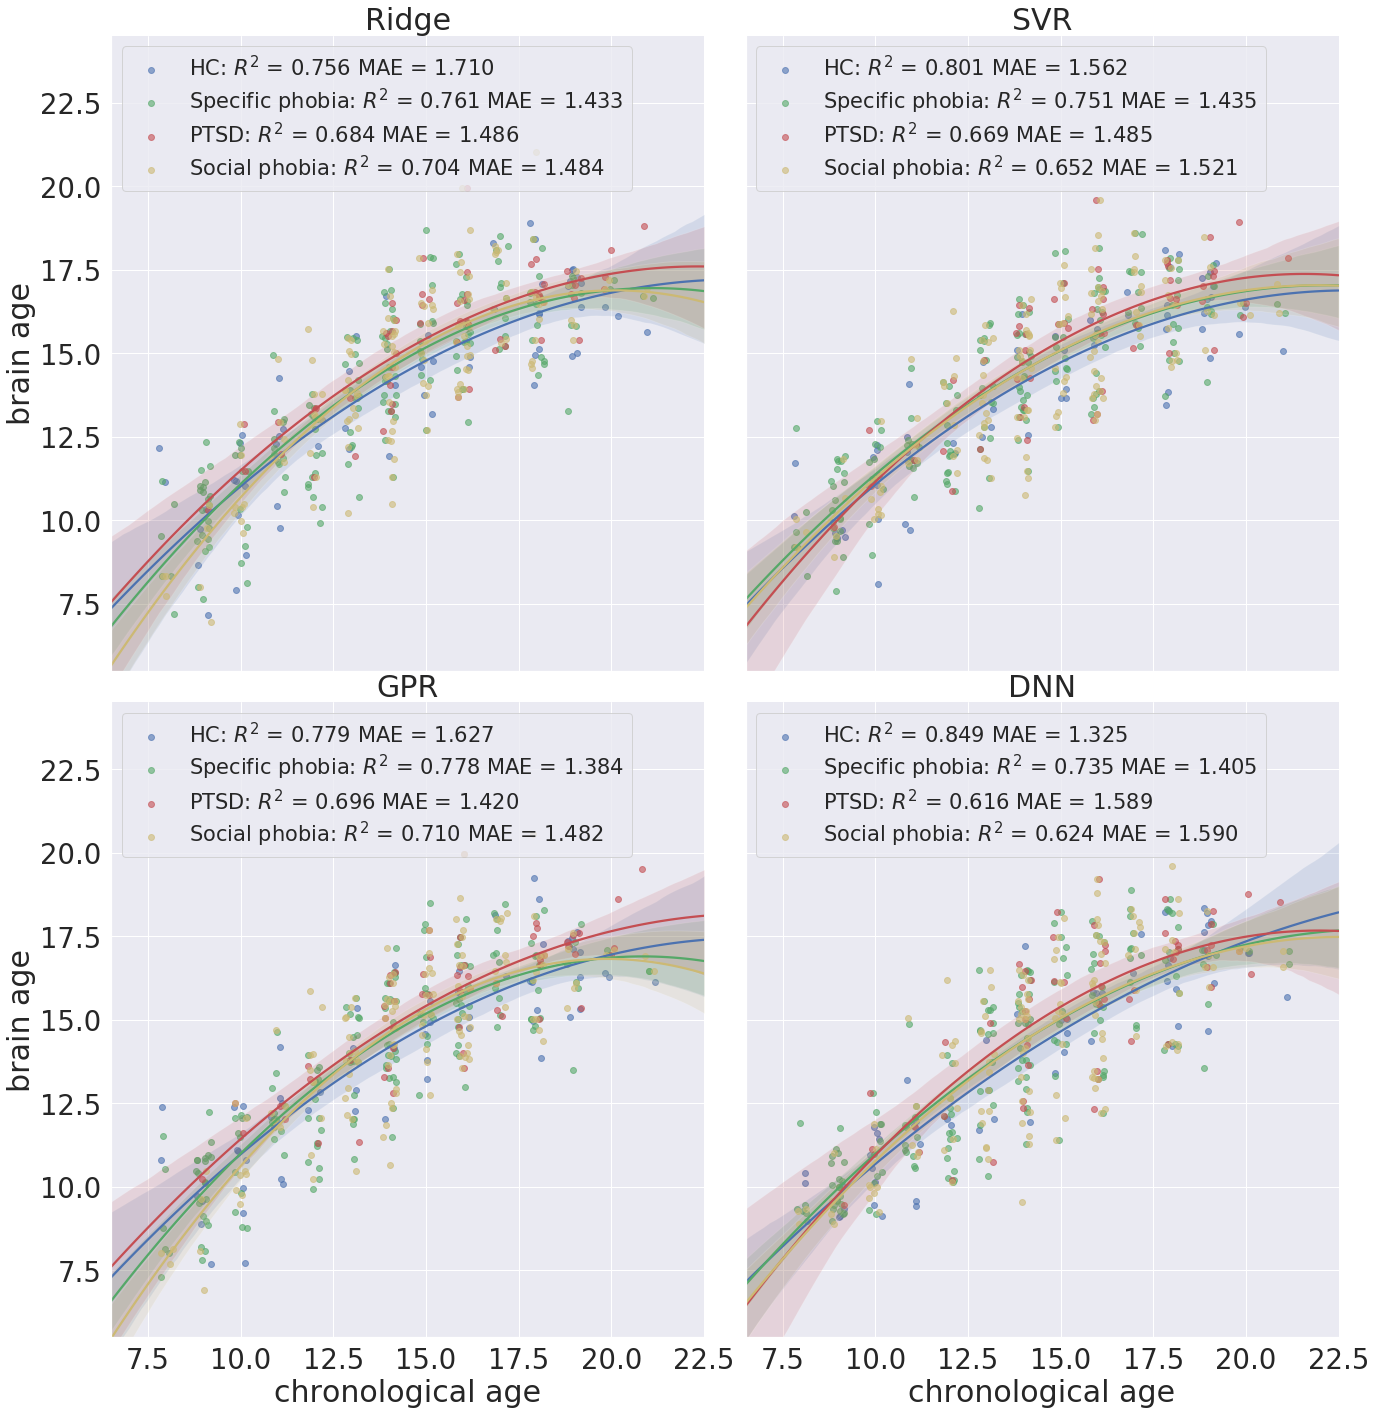

In [17]:
plot_result_group(scatter_data)
plt.subplots_adjust(left = .1, bottom = .07, right = .93, top = .95, hspace=0.05, wspace=0.07)
# plt.margins(0.25)

plt.savefig('figure/figure4_scatter_disorders_merge.png', format = 'png', dpi=300)

In [18]:
from my_fun import qudratic_r_squared
disorders_name = ['HC', 'Specific phobia', 'PTSD', 'Social phobia']
disorders = ['HC', 'smry_phb', 'smry_ptd', 'smry_soc']

def plot_result_group_single_method(plot_data, method_name):
    
    plot_data2 = plot_data.loc[method_name]
    #disorders = plot_data['group'].unique()
    sns.set(rc={'figure.figsize':(15,15)}, font_scale = 2.5)

        
    for i_dis in range(len(disorders)):

        y_dis = plot_data2.loc[plot_data2['group']==disorders[i_dis], 'chronological age']
        y_pred = plot_data2.loc[plot_data2['group']==disorders[i_dis], 'brain age']

        r_dis = np.corrcoef(y_dis, y_pred)
        r_squared = qudratic_r_squared(y_dis, y_pred)
        rmse_dis = np.sqrt(np.mean(np.square(y_dis - y_pred)))
        mae_dis = np.mean(np.abs(y_dis - y_pred))

        #label = disorders[i_dis] + ": r = %.3f MAE = %.3f" % (r_dis[1,0], mae_dis)
        label = disorders_name[i_dis] + ": $R^2$ = %.3f MAE = %.3f" % (r_squared, mae_dis)

        ax = sns.regplot(x=y_dis, y=y_pred, label = label, order = 2, scatter_kws = {'alpha': .6}, x_jitter = 0.2)
        ax.legend(loc="upper left", fontsize = 15, labelspacing = .3)
        #ax.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), ncol=1)
        ax.set(xlabel='chronological age', ylabel='brain age')
        ax.set(ylim = [5, 22])
        ax.set(xlim = [7, 22])
        #plt.setp(ax.get_legend().get_texts(), fontsize='15') # for legend text
        #plt.setp(ax.get_legend().get_title(), fontsize='15') # for legend title
        

In [19]:
# plot_result_group_single_method(scatter_data, 'Ridge')

In [20]:
# plot_result_group_single_method(scatter_data, 'SVR')

In [21]:
# plot_result_group_single_method(scatter_data, 'GPR')

In [22]:
# plot_result_group_single_method(scatter_data, 'DNN')

In [23]:
scatter_data_dnn = scatter_data.loc['DNN']
scatter_data_dnn.head()

,CV,SUBJID,Sex,age gap,age gap corr,age gap corr intersex,age gap corr sex,brain age,brain age fit,brain age fit intersex,brain age fit sex,chronological age,group
0,10,600641554524,F,2.432531,2.043445,1.727209,1.893902,16.432531,14.389086,14.705322,14.538629,14.0,smry_phb
1,9,609289117165,F,0.626188,1.812511,1.956714,1.679376,18.626188,16.813677,16.669474,16.946812,18.0,smry_phb
2,9,609289117165,F,0.626188,1.812511,1.956714,1.679376,18.626188,16.813677,16.669474,16.946812,18.0,smry_ptd
3,9,609289117165,F,0.626188,1.812511,1.956714,1.679376,18.626188,16.813677,16.669474,16.946812,18.0,smry_soc
4,9,601735116940,F,-0.469157,-0.209843,-0.349297,-0.352465,15.530843,15.740686,15.880140,15.883308,16.0,smry_phb


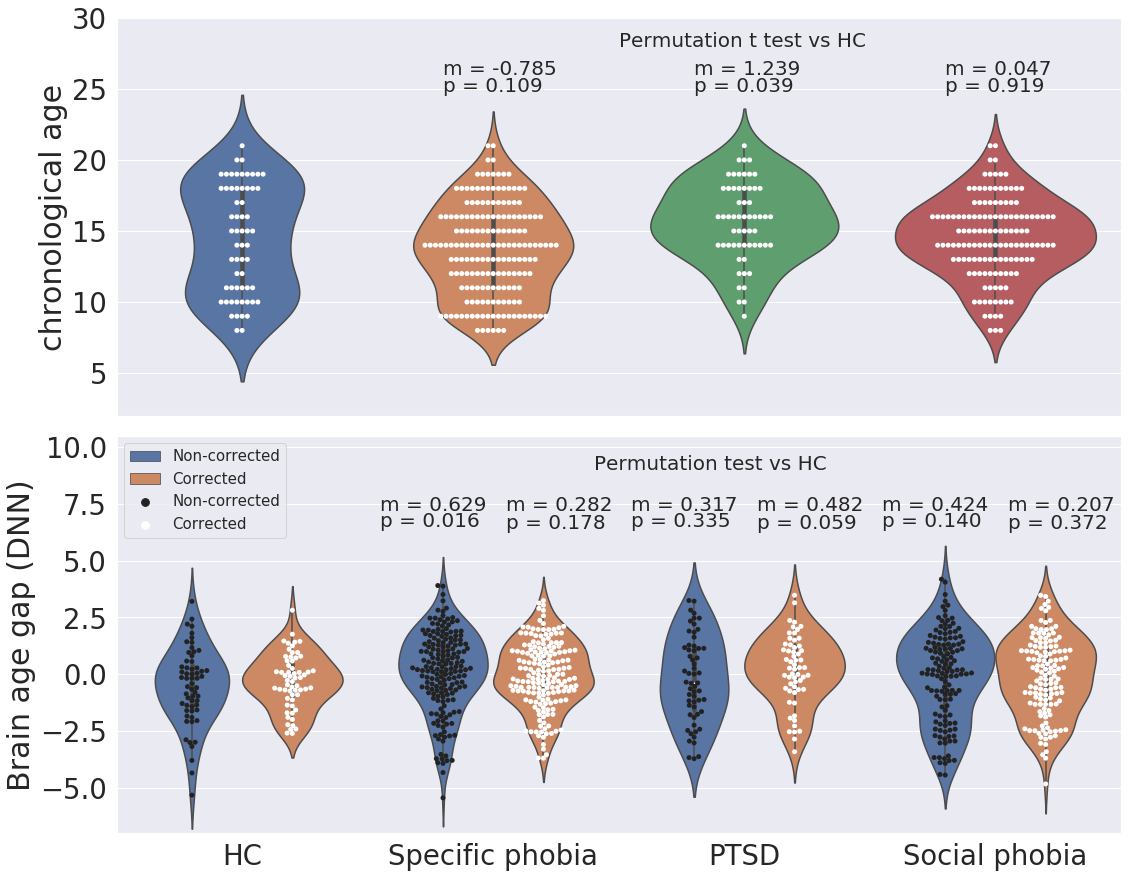

In [24]:
#permutation test of brain age gap:
from mlxtend.evaluate import permutation_test

disorders_name = ['HC', 'Specific phobia', 'PTSD', 'Social phobia']
disorders = ['HC', 'smry_phb', 'smry_ptd', 'smry_soc']

sns.set(rc={'figure.figsize':(18,15)})
sns.set(font_scale=2.5)

f, (ax1, ax2) = plt.subplots(2, sharex=True)

########################################## plot age: ######################################

sns.violinplot(y = "chronological age", x = "group", data = scatter_data_dnn, bw = 'silverman', 
               order=disorders, ax = ax1)
sns.swarmplot(y="chronological age", x= "group", data=scatter_data_dnn, color="white", 
              order=disorders, ax = ax1)
ax1.set_ylim(2,30)

ax1.text(2-.5, 28, 'Permutation t test vs HC', fontsize = 20)

age_hc = scatter_data_dnn.loc[scatter_data_dnn['group']=='HC', 'chronological age']

for i_dis in range(1, len(disorders)):
    
    age_dis = scatter_data_dnn.loc[scatter_data_dnn['group'] == disorders[i_dis], 'chronological age']
    p_dis = permutation_test(age_dis, age_hc, method='approximate', num_rounds=1000, seed=0)
    m_dis = np.mean(age_dis) - np.mean(age_hc)
    
    txt1 = "p = %.3f" % p_dis
    ax1.text(-.2+i_dis, 24.8, txt1, fontsize = 20)
    
    txt1 = "m = %.3f" % m_dis
    ax1.text(-.2+i_dis, 26, txt1, fontsize = 20)

ax1.set(ylabel="chronological age", xlabel='')
#plt.title("Ridge")
# ax.set_xticklabels(labels=['HC']+disorders_name)
plt.xticks(rotation = 30)


####################################### plot age gap: ##########################################

plot_data = pd.melt(scatter_data_dnn, id_vars = 'group', value_vars = ['age gap', 'age gap corr'], 
                    var_name = 'bias correction', value_name = 'age gap')
plot_data.replace({'bias correction': {'age gap': 'Non-corrected', 'age gap corr': 'Corrected'}}, inplace = True)

sns.violinplot(y = "age gap", x = "group", data = plot_data, hue = 'bias correction', split=False,
               order=disorders, ax = ax2)

sns.swarmplot(y = "age gap", x = "group", data = plot_data, hue = 'bias correction', color = 'white', dodge=True, 
              order=disorders, ax = ax2)

# ax.legend_.remove()
plt.legend(loc = 'upper left', prop = {'size': 15})
ax2.set_ylim(-7, 10.5)

age_gap_hc = scatter_data_dnn.loc[scatter_data_dnn['group']=='HC', 'age gap']
age_gap_hc_corr = scatter_data_dnn.loc[scatter_data_dnn['group']=='HC', 'age gap corr']

for i_dis in range(1, len(disorders)):
    
    age_gap = scatter_data_dnn.loc[scatter_data_dnn['group'] == disorders[i_dis], 'age gap']
    age_gap_corr = scatter_data_dnn.loc[scatter_data_dnn['group'] == disorders[i_dis], 'age gap corr']
    
    p_age_gap = permutation_test(age_gap, age_gap_hc, method='approximate',num_rounds=1000,seed=7)
    m_age_gap = np.mean(age_gap) - np.mean(age_gap_hc)

    txt1 = "p = %.3f" % p_age_gap
    ax2.text(-.45+i_dis, 6.5, txt1, fontsize = 20)
    
    txt1 = "m = %.3f" % m_age_gap
    ax2.text(-.45+i_dis, 7.2, txt1, fontsize = 20)
    
    p_age_gap_corr = permutation_test(age_gap_corr, age_gap_hc_corr, method='approximate',num_rounds=1000,seed=7)
    m_age_gap_corr = np.mean(age_gap_corr) - np.mean(age_gap_hc_corr)
    
    txt1 = "p = %.3f" % p_age_gap_corr
    ax2.text(.05+i_dis, 6.4, txt1, fontsize = 20)
    
    txt1 = "m = %.3f" % m_age_gap_corr
    ax2.text(.05+i_dis, 7.2, txt1, fontsize = 20)

ax2.text(-.6+2, 9, 'Permutation test vs HC', fontsize = 20)
ax2.set(ylabel="Brain age gap (DNN)", xlabel="")
ax2.set_xticklabels(labels=disorders_name)
# plt.title(method)
plt.xticks(rotation = 0)

plt.subplots_adjust(hspace=0.05, wspace=0.05)

In [25]:
scatter_data_ridge = scatter_data.loc['Ridge']
scatter_data_ridge.head()

scatter_data_svr = scatter_data.loc['SVR']

scatter_data_gpr = scatter_data.loc['GPR']

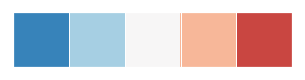

In [26]:
sns.palplot(sns.color_palette("RdBu_r", 5))

In [37]:
colors = sns.color_palette("RdBu_r", 7)
colors = [colors[5], colors[1]]
#colors = [sns.xkcd_rgb["amber"], sns.xkcd_rgb["windows blue"], ]

#permutation test of brain age gap:
from mlxtend.evaluate import permutation_test

disorders_name = ['HC', 'Specific phobia', 'PTSD', 'Social phobia']
disorders = ['HC', 'smry_phb', 'smry_ptd', 'smry_soc']

sns.set(rc={'figure.figsize':(18,15)})
sns.set(font_scale=2.5)

def plot_age_gap(plot_data, ylabel = "Brain age gap"):
    f, (ax1, ax2) = plt.subplots(2, sharex=True)

    ########################################## plot age: ######################################

    sns.violinplot(y = "chronological age", x = "group", hue = 'Sex', data = plot_data, bw = 'silverman', 
                   palette = colors, order=disorders, ax = ax1)
    sns.swarmplot(y="chronological age", x= "group",  hue = 'Sex', dodge=True, data=plot_data, color="white",
                  order=disorders, ax = ax1)
    ax1.set_ylim(2,33)
    lgd = ax1.legend(loc = 'upper left', prop = {'size': 13}, title = 'Gender')
    lgd.get_title().set_fontsize('15') 

    ax1.text(2-.5, 30.5, 'Permutation t test vs HC', fontsize = 20)

    age_hc = plot_data.loc[plot_data['group']=='HC', 'chronological age']
    age_hc_male = plot_data.loc[(plot_data['group']=='HC') & (plot_data['Sex']=='M'), 'chronological age']
    age_hc_female = plot_data.loc[(plot_data['group']=='HC') & (plot_data['Sex']=='F'), 'chronological age']

    for i_dis in range(1, len(disorders)):

        age_dis = plot_data.loc[plot_data['group'] == disorders[i_dis], 'chronological age']
        age_dis_m = plot_data.loc[(plot_data['group'] == disorders[i_dis]) & (plot_data['Sex']=='M'), 
                                  'chronological age']
        age_dis_f = plot_data.loc[(plot_data['group'] == disorders[i_dis]) & (plot_data['Sex']=='F'), 
                                  'chronological age']

        p_dis = permutation_test(age_dis, age_hc, method='approximate', num_rounds=1000, seed=0)
        m_dis = np.mean(age_dis) - np.mean(age_hc)
        
        p_dis_m = permutation_test(age_dis_m, age_hc_male, method='approximate', num_rounds=1000, seed=0)
        m_dis_m = np.mean(age_dis_m) - np.mean(age_hc_male)

        p_dis_f = permutation_test(age_dis_f, age_hc_female, method='approximate', num_rounds=1000, seed=0)
        m_dis_f = np.mean(age_dis_f) - np.mean(age_hc_female)

        # combined:
        txt1 = "p=%.3f" % p_dis
        ax1.text(-.2+i_dis, 27.6, txt1, fontsize = 20)

        txt1 = "d=%.3f" % m_dis
        ax1.text(-.2+i_dis, 28.8, txt1, fontsize = 20)
        
        # males:
        txt1 = "p=%.3f" % p_dis_m
        ax1.text(-.0+i_dis, 24.8, txt1, fontsize = 20)

        txt1 = "d=%.3f" % m_dis_m
        ax1.text(-.0+i_dis, 26, txt1, fontsize = 20)

        # females:
        txt1 = "p=%.3f" % p_dis_f
        ax1.text(-.4+i_dis, 24.8, txt1, fontsize = 20)

        txt1 = "d=%.3f" % m_dis_f
        ax1.text(-.4+i_dis, 26, txt1, fontsize = 20)

    ax1.set(ylabel="chronological age", xlabel='')
    #plt.title("Ridge")
    # ax.set_xticklabels(labels=['HC']+disorders_name)
    plt.xticks(rotation = 30)


    ####################################### plot age gap: ##########################################

    plot_data_sub = pd.melt(plot_data, id_vars = 'group', 
                            value_vars = ['age gap', 'age gap corr sex', 'age gap corr intersex'], 
                            var_name = 'bias correction', value_name = 'age gap')
    
    plot_data_sub.replace({'bias correction': {'age gap': 'No correction', 
                                               'age gap corr sex': 'Correction1', 
                                               'age gap corr intersex': 'Correction2'}}, 
                          inplace = True)

    sns.violinplot(y = "age gap", x = "group", data = plot_data_sub, hue = 'bias correction', split=False,
                   order=disorders, ax = ax2)

    sns.swarmplot(y = "age gap", x = "group", data = plot_data_sub, hue = 'bias correction', color = 'white', dodge=True, 
                  order=disorders, ax = ax2)
    # plt.title("SVR")
    # ax.legend_.remove()
    lgd = ax2.legend(loc = 'upper left', prop = {'size': 13}, title = 'Bias correction')
    lgd.get_title().set_fontsize('16') 
    ax2.set_ylim(-7, 10.5)

    age_gap_hc = plot_data.loc[plot_data['group']=='HC', 'age gap']
    age_gap_hc_corr = plot_data.loc[plot_data['group']=='HC', 'age gap corr sex']
    age_gap_hc_corr2 = plot_data.loc[plot_data['group']=='HC', 'age gap corr intersex']

    for i_dis in range(1, len(disorders)):
        # age gap:
        age_gap = plot_data.loc[plot_data['group'] == disorders[i_dis], 'age gap']
        
        p_age_gap = permutation_test(age_gap, age_gap_hc, method='approximate',num_rounds=1000,seed=7)
        m_age_gap = np.mean(age_gap) - np.mean(age_gap_hc)

        txt1 = "p=%.3f" % p_age_gap
        ax2.text(-.47+i_dis, 6.5, txt1, fontsize = 19)

        txt1 = "d=%.3f" % m_age_gap
        ax2.text(-.47+i_dis, 7.2, txt1, fontsize = 19)
        
        # age gap corr:
        age_gap_corr = plot_data.loc[plot_data['group'] == disorders[i_dis], 'age gap corr sex']
        p_age_gap_corr = permutation_test(age_gap_corr, age_gap_hc_corr, method='approximate',num_rounds=1000,seed=7)
        m_age_gap_corr = np.mean(age_gap_corr) - np.mean(age_gap_hc_corr)

        txt1 = "p=%.3f" % p_age_gap_corr
        ax2.text(-.15+i_dis, 6.4, txt1, fontsize = 19)

        txt1 = "d=%.3f" % m_age_gap_corr
        ax2.text(-.15+i_dis, 7.2, txt1, fontsize = 19)
        
        # age gap corr2:
        age_gap_corr = plot_data.loc[plot_data['group'] == disorders[i_dis], 'age gap corr intersex']
        p_age_gap_corr = permutation_test(age_gap_corr, age_gap_hc_corr2, method='approximate',num_rounds=1000,seed=7)
        m_age_gap_corr = np.mean(age_gap_corr) - np.mean(age_gap_hc_corr)

        txt1 = "p=%.3f" % p_age_gap_corr
        ax2.text(.17+i_dis, 6.4, txt1, fontsize = 19)

        txt1 = "d=%.3f" % m_age_gap_corr
        ax2.text(.17+i_dis, 7.2, txt1, fontsize = 19)

    ax2.text(-.6+2, 9, 'Permutation test vs HC', fontsize = 20)
    ax2.set(ylabel=ylabel, xlabel="")
    ax2.set_xticklabels(labels=disorders_name)

    plt.xticks(rotation = 0)

    plt.subplots_adjust(left = .1, top = .95, right = .95, bottom = .07, hspace=0.05, wspace=0.05)

In [38]:
plot_data.head()

,CV,SUBJID,Sex,age gap,age gap corr,age gap corr intersex,age gap corr sex,brain age,brain age fit,brain age fit intersex,brain age fit sex,chronological age,group
0,10,600641554524,F,0.311545,-0.106529,-0.451227,-0.287030,14.311545,14.418074,14.762772,14.598575,14.0,smry_phb
1,9,609289117165,F,-0.815399,0.680265,0.791419,0.519568,17.184601,16.504336,16.393183,16.665033,18.0,smry_phb
2,9,609289117165,F,-0.815399,0.680265,0.791419,0.519568,17.184601,16.504336,16.393183,16.665033,18.0,smry_ptd
3,9,609289117165,F,-0.815399,0.680265,0.791419,0.519568,17.184601,16.504336,16.393183,16.665033,18.0,smry_soc
4,9,601735116940,F,0.331277,0.740141,0.570394,0.567992,16.331277,15.591136,15.760883,15.763285,16.0,smry_phb


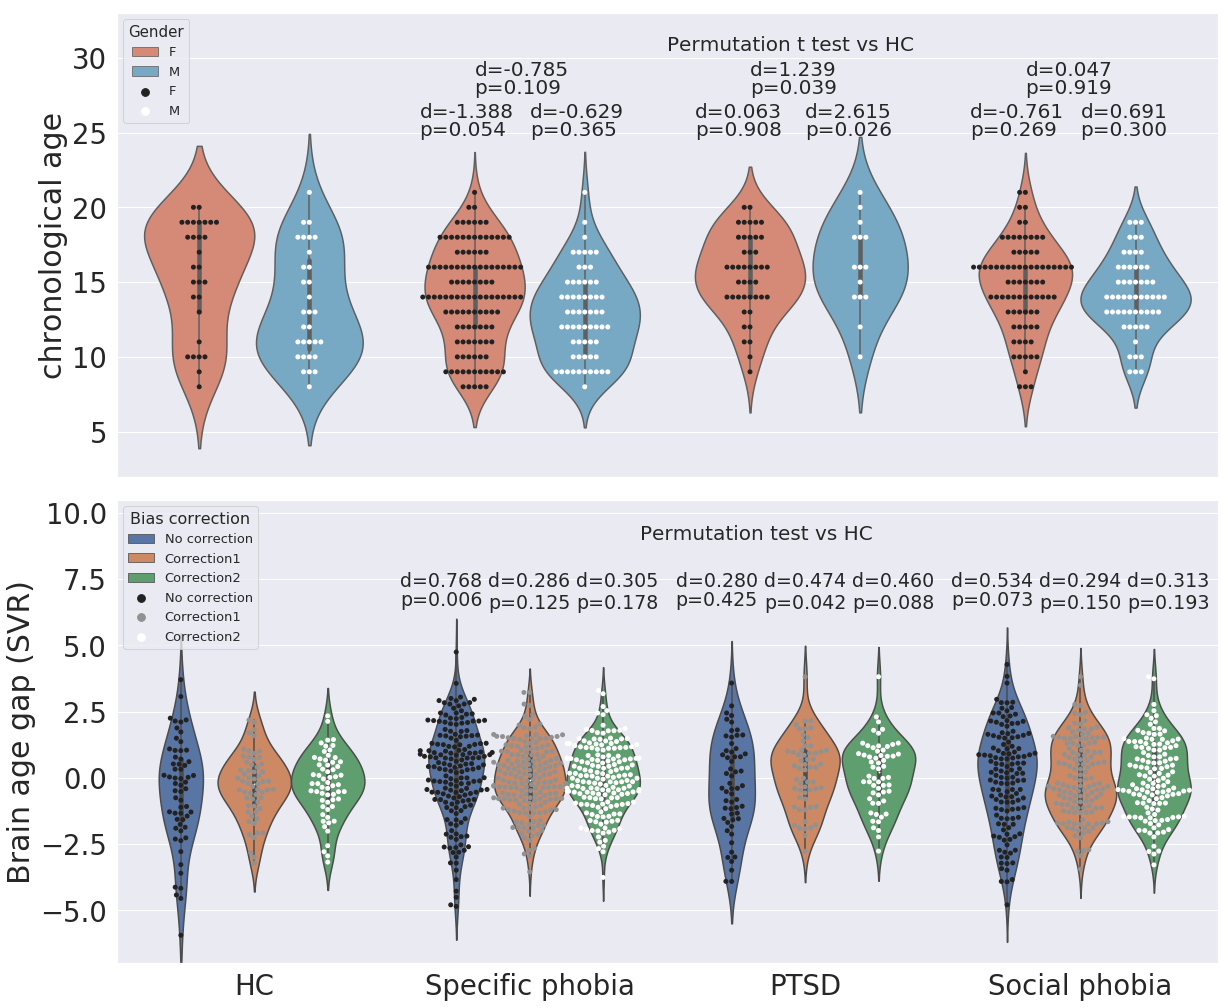

In [39]:
plot_data = scatter_data_svr
plot_age_gap(plot_data, "Brain age gap (SVR)")
plt.savefig('figure/figure5_brain_age_gap_disorders_svr.jpg', format = 'jpg', dpi=300)

In [ ]:
plot_data = scatter_data_dnn
plot_age_gap(plot_data, "Brain age gap (DNN)")
plt.savefig('figure/figure5_brain_age_gap_disorders_dnn.png', dpi=300)